In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
from scipy.io import loadmat
import glob
import matplotlib.pyplot as matplot_plt
from collections import defaultdict

/tamir2/moranb/microbiome/Igem_TAU_2021/venv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sys.path.append(str(Path(os.path.dirname(os.getcwd())).parent))

In [3]:
from Bio import SeqIO
from analysis.orf_model_analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data
from analysis.orf_model_analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus

from modules.main import run_modules

In [4]:
base_path = os.path.join(Path(os.getcwd()).parent.resolve(), "example_data")
macherry_file_path = os.path.join(base_path, "mCherry_original.fasta")

In [5]:
macherry_file_path

'/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/example_data/mCherry_original.fasta'

In [6]:
with open(macherry_file_path, "r") as mcherry_fasta_file:
    mcherry_dict = SeqIO.to_dict(SeqIO.parse(mcherry_fasta_file, "fasta"))

original_mcherry_seq = str(list(mcherry_dict.values())[0].seq)

# mCherry Variants Analysis

In [7]:
mcherry_variants_file_path = Path(base_path).parent.resolve() / "initiation_model_analysis" / "old_mcherry_variants.fasta"

In [8]:
with open(mcherry_variants_file_path, "r") as mcherry_fasta_file:
    mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_fasta_file, "fasta"))

## Whole prefix FE

In [9]:
num_of_codons = 15
num_of_codons_in_nt = num_of_codons * 3

In [10]:
# for variant, variant_seq in mcherry_variants_dict.items():
#     assert str(variant_seq.seq[:num_of_codons_in_nt]) == original_mcherry_seq[:num_of_codons_in_nt]

In [11]:
from RNA import RNA 

In [12]:
original_mcherry_mfe =  RNA.fold(original_mcherry_seq[:num_of_codons_in_nt])[1]

In [13]:
original_mcherry_mfe

-4.400000095367432

In [14]:
mfe_values = {}
for variant, variant_seq in mcherry_variants_dict.items():
    mfe_values[variant] = RNA.fold(str(variant_seq.seq)[:num_of_codons_in_nt])[1]

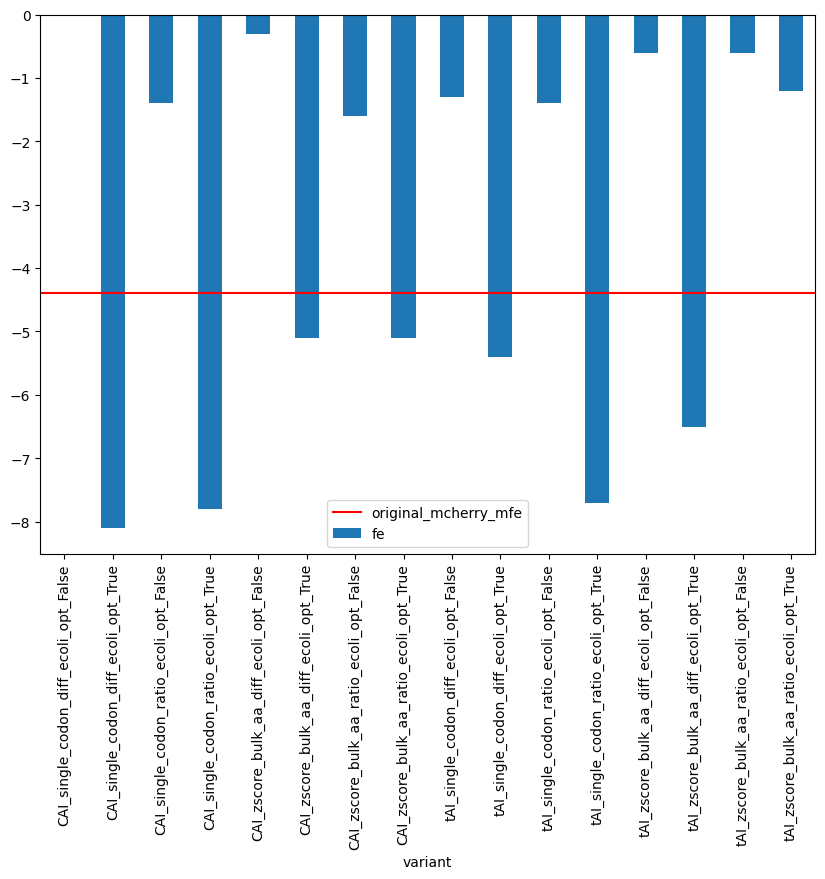

In [15]:
mfe_values_df = pd.DataFrame(data={"variant":mfe_values.keys(), "fe":mfe_values.values()})
mfe_values_df
plt = mfe_values_df.plot(x="variant", y="fe", kind="bar", figsize=(10, 7))
plt.axhline(y=original_mcherry_mfe, color='r', linestyle='-', label="original_mcherry_mfe")
plt.legend()

## Mean prefix FE

In [16]:
mcherry_plasmid_seq_file_path = Path(base_path).parent.resolve() / "initiation_model_analysis" / "AEC802-ECE15-P43_synthRBS_mCherry with Amp from Shira.fa"

In [17]:
with open(mcherry_plasmid_seq_file_path, "r") as mcherry_plasmid:
    mcherry_plasmid_dict = SeqIO.to_dict(SeqIO.parse(mcherry_plasmid, "fasta"))

In [18]:
mcherry_plasmid_seq = str(mcherry_plasmid_dict["AEC802-ECE15-P43_synthRBS_mCherry"].seq).lower()

In [19]:
mcherry_orf_start_index = 560

assert mcherry_plasmid_seq[mcherry_orf_start_index:mcherry_orf_start_index+len(original_mcherry_seq)] == original_mcherry_seq.lower()

In [20]:
def calc_fe_profile(seq, orf_start_index, fe_range):
    seqs = []
    for i in range(orf_start_index - fe_range[0] + 1 , orf_start_index + fe_range[1] - 1):
        tmp_str = seq[i: i+window_size_in_nt]
        tmp_fe = RNA.fold(tmp_str)[1]
        seqs.append(tmp_fe)
    return seqs

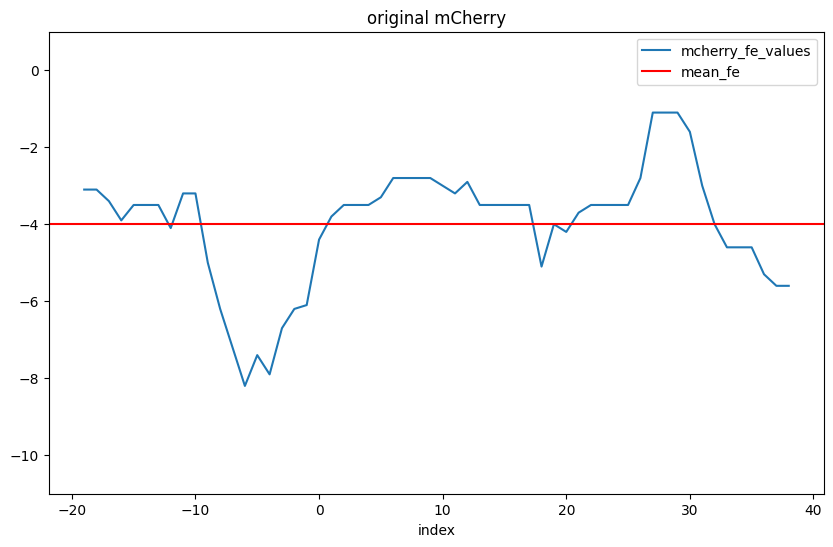

In [21]:
mcherry_orf_start_index = 560
window_size_in_nt = 39
fe_range = [20, 40]

mcherry_seqs = calc_fe_profile(mcherry_plasmid_seq, mcherry_orf_start_index, fe_range)
original_mcherry_mfe = sum(mcherry_seqs)/len(mcherry_seqs)

mcherry_fe_df = pd.DataFrame(data={"mcherry_fe_values":mcherry_seqs, "index":range(-fe_range[0]+1,fe_range[1]-1)})
plt = mcherry_fe_df.plot(x="index", y="mcherry_fe_values", title = "original mCherry", ylim=(-11,1), figsize=(10,6))
plt.axhline(y=original_mcherry_mfe, color='r', linestyle='-', label="mean_fe")
plt.legend()

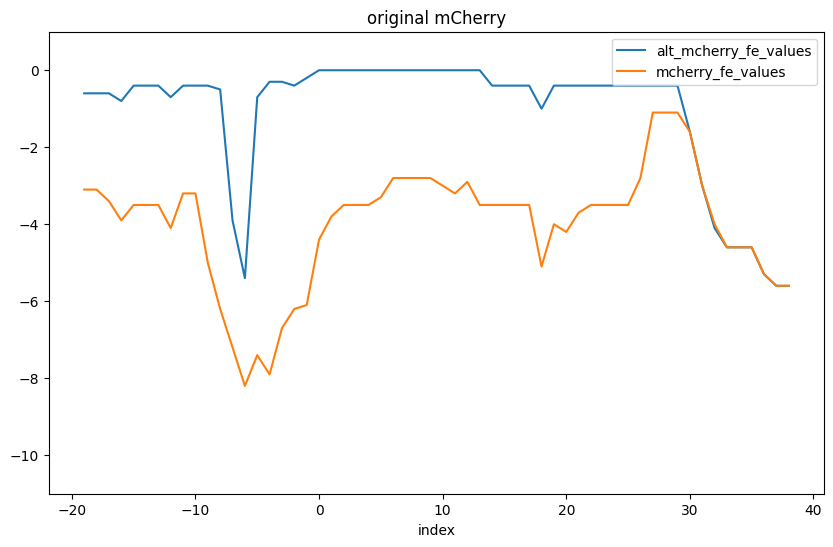

In [22]:
promoter = mcherry_plasmid_seq[mcherry_orf_start_index-40: mcherry_orf_start_index]
alternative_mcherry_orf = "ATGGTTTCAAAAGGGGAGGAGGACAATATGGCAATTATCAAAGAATTCATGCGCTTCAAAGTTCACATGGAGGGTTCTGTTAACGGTCACGAGTTCGAGATCGAAGGCGAAGGCGAGGGCCGTCCGTATGAAGGCACCCAGACCGCCAAACTGAAAGTGACTAAAGGCGGCCCGCTGCCTTTTGCGTGGGACATCCTGAGCCCGCAATTTATGTACGGTTCTAAAGCGTATGTTAAACACCCAGCGGATATCCCGGACTATCTGAAGCTGTCTTTTCCGGAAGGTTTCAAGTGGGAACGCGTAATGAATTTTGAAGATGGTGGTGTCGTGACCGTCACTCAGGACTCCTCCCTGCAGGATGGCGAGTTCATCTATAAAGTTAAACTGCGTGGTACTAATTTTCCATCTGATGGCCCGGTGATGCAGAAAAAGACGATGGGTTGGGAGGCGTCTAGCGAACGCATGTATCCGGAAGATGGTGCGCTGAAAGGCGAAATTAAACAGCGCCTGAAACTGAAAGATGGCGGCCATTATGACGCTGAAGTGAAAACCACGTACAAAGCCAAGAAACCTGTGCAGCTGCCTGGCGCGTACAATGTGAATATTAAACTGGACATCACCTCTCATAATGAAGATTATACGATCGTAGAGCAATATGAGCGCGCGGAGGGTCGTCATTCTACCGGTGGCATGGATGAGCTGTACAAATAA"
alternative_mcherry_orf_with_prommoter = promoter + alternative_mcherry_orf
alternative_mcherry_orf_with_prommoter = alternative_mcherry_orf_with_prommoter.lower()

mcherry_seqs = calc_fe_profile(alternative_mcherry_orf_with_prommoter, len(promoter), fe_range)
alt_mcherry_mfe = sum(mcherry_seqs)/len(mcherry_seqs)

alt_mcherry_fe_df = pd.DataFrame(data={"alt_mcherry_fe_values":mcherry_seqs, "index":range(-fe_range[0]+1,fe_range[1]-1)})
plt = alt_mcherry_fe_df.plot(x="index", y="alt_mcherry_fe_values", title = "original mCherry", ylim=(-11,1), figsize=(10,6))
mcherry_fe_df.plot(ax=plt, x="index", y="mcherry_fe_values", ylim=(-11,1))
# plt.axhline(y=original_mcherry_mfe, color='r', linestyle='-', label="mean_fe")
plt.legend()

In [23]:
# result = loadmat("/tamir2/moranb/microbiome/folding_opt/promoters/output/optimize/mCherry/1/mCherry mCherry mCherry ORF profile.mat")
# seqs = result["temp_res"][0]

# original_mcherry_mfe = sum(seqs)/len(seqs)

# offset = 20
# matlab_orf_start_index = 37
# seqs = seqs[matlab_orf_start_index-fe_range[0]+1:matlab_orf_start_index+fe_range[1]-1]

# mcherry_fe_df = pd.DataFrame(data={"mcherry_fe_values":seqs, "index":range(-fe_range[0]+1,fe_range[1]-1)})
# plt = mcherry_fe_df.plot(x="index", y="mcherry_fe_values", title = "original mCherry", ylim=(-11,1), figsize=(10,6))
# plt.axhline(y=original_mcherry_mfe, color='r', linestyle='-', label="mean_fe")
# plt.legend()

In [24]:
promoter = mcherry_plasmid_seq[mcherry_orf_start_index-40: mcherry_orf_start_index]
print(f"promoter: {promoter}")
variants_mfe_values = {"variant":[], "mfe": [], "variant_fe_values": []}
for variant, variant_seq in mcherry_variants_dict.items():
    variant_seq_with_promoter = promoter + str(variant_seq.seq)
    variant_seq_with_promoter = variant_seq_with_promoter.lower()
    variant_orf_start_index = len(promoter)

    variant_seqs = calc_fe_profile(variant_seq_with_promoter, variant_orf_start_index, fe_range)
    
    avg_variant_fe = sum(variant_seqs)/len(variant_seqs)
    variants_mfe_values["variant"].append(variant)
    variants_mfe_values["mfe"].append(avg_variant_fe)
    variants_mfe_values["variant_fe_values"].append(variant_seqs)

promoter: tgcacgaataaattagcaataaaaggaggttacagctagc


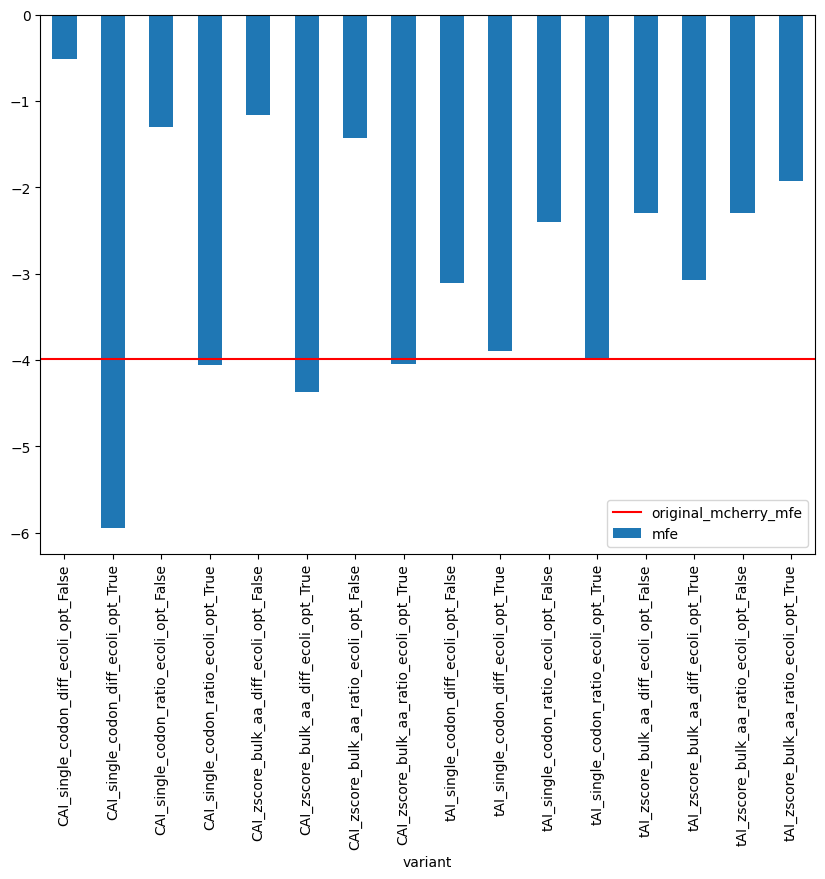

In [25]:
variants_mfe_values_df = pd.DataFrame(variants_mfe_values)
plt = variants_mfe_values_df.plot("variant", "mfe", kind="bar", figsize=(10, 7))
plt.axhline(y=original_mcherry_mfe, color='r', linestyle='-', label="original_mcherry_mfe")
plt.legend()

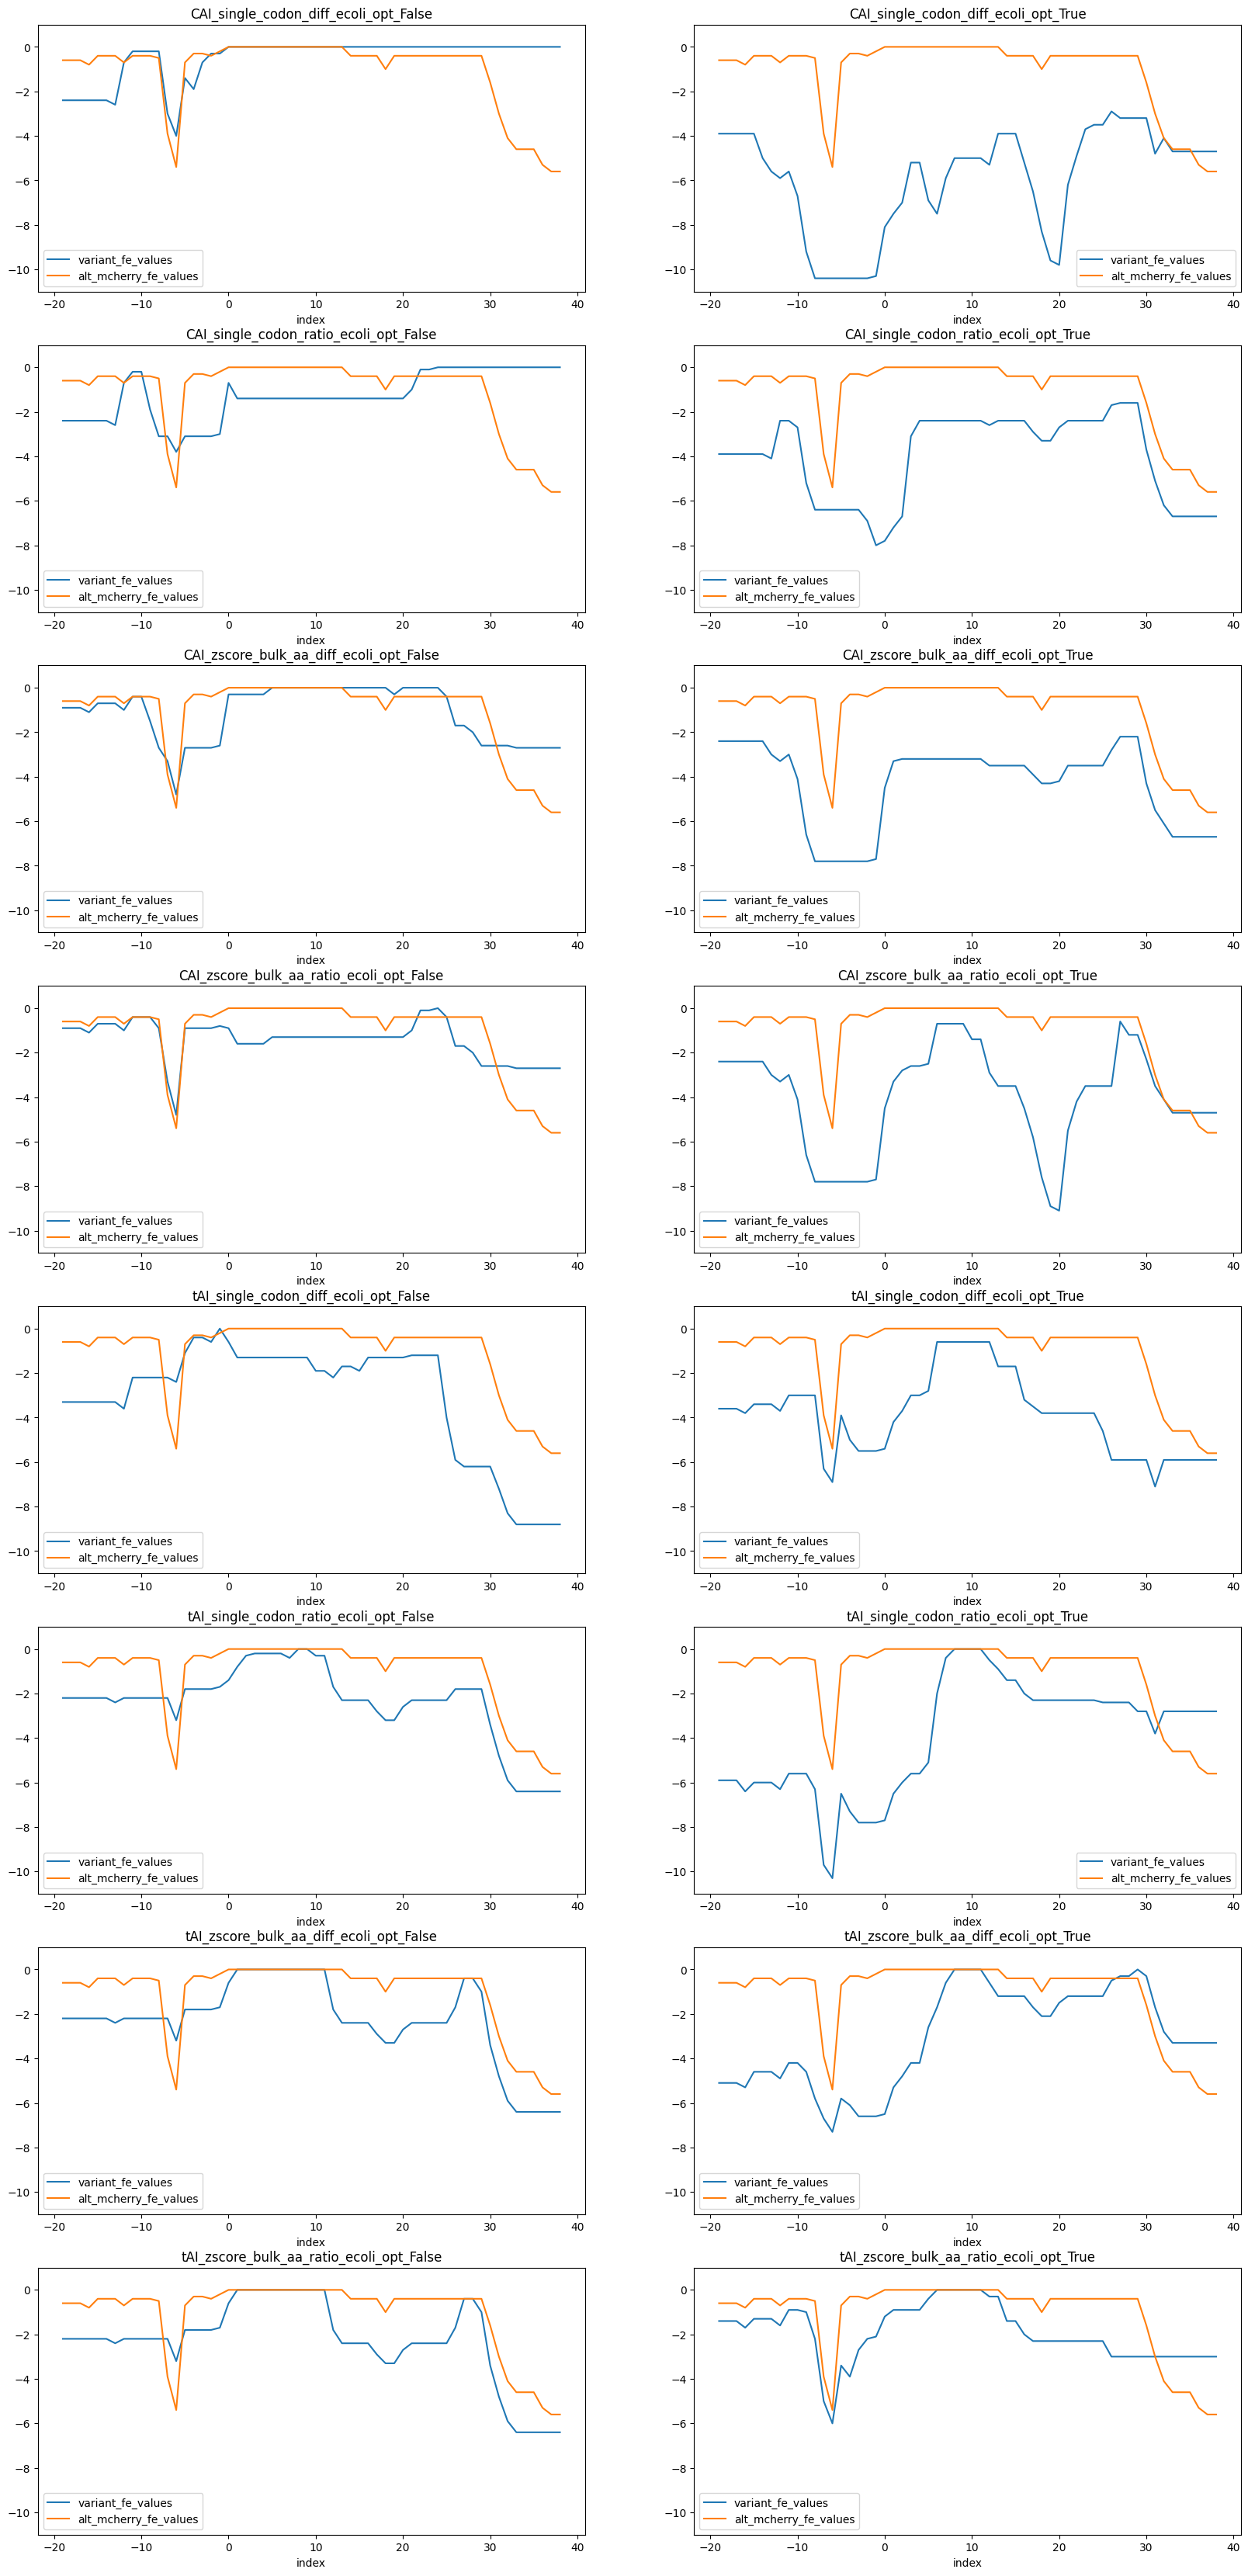

In [26]:
figure, axis = matplot_plt.subplots(8, 2, figsize=(20,42))
for q in range(variants_mfe_values_df.shape[0]):
    x= variants_mfe_values_df.iloc[q, :]
    variant_df = pd.DataFrame(data={"variant_fe_values":x["variant_fe_values"], "index":range(-fe_range[0]+1,fe_range[1]-1)})
    plt = variant_df.plot(x="index", y="variant_fe_values", title = x["variant"], ax=axis[q//2, q%2], ylim=(-11,1))
    alt_mcherry_fe_df.plot(ax=plt, x="index", y="alt_mcherry_fe_values", ylim=(-11,1))
    # plt.axhline(y=x["mfe"], color='r', linestyle='-', label="mean_fe")
    plt.legend()

In [27]:
variants_mfe_values_df

,variant,mfe,variant_fe_values
0,CAI_single_codon_diff_ecoli_opt_False,-0.518966,"[-2.4000000953674316, -2.4000000953674316, -2...."
1,CAI_single_codon_diff_ecoli_opt_True,-5.946552,"[-3.9000000953674316, -3.9000000953674316, -3...."
2,CAI_single_codon_ratio_ecoli_opt_False,-1.298276,"[-2.4000000953674316, -2.4000000953674316, -2...."
3,CAI_single_codon_ratio_ecoli_opt_True,-4.062069,"[-3.9000000953674316, -3.9000000953674316, -3...."
4,CAI_zscore_bulk_aa_diff_ecoli_opt_False,-1.165517,"[-0.8999999761581421, -0.8999999761581421, -0...."
5,CAI_zscore_bulk_aa_diff_ecoli_opt_True,-4.374138,"[-2.4000000953674316, -2.4000000953674316, -2...."
6,CAI_zscore_bulk_aa_ratio_ecoli_opt_False,-1.434483,"[-0.8999999761581421, -0.8999999761581421, -0...."
7,CAI_zscore_bulk_aa_ratio_ecoli_opt_True,-4.046552,"[-2.4000000953674316, -2.4000000953674316, -2...."
8,tAI_single_codon_diff_ecoli_opt_False,-3.112069,"[-3.299999952316284, -3.299999952316284, -3.29..."
9,tAI_single_codon_diff_ecoli_opt_True,-3.901724,"[-3.5999999046325684, -3.5999999046325684, -3...."


## Matlab code

In [28]:
orf_start_index = 560
window_size_in_nt = 40
mid= window_size_in_nt // 2
seqs = []
for i in range(orf_start_index, orf_start_index + window_size_in_nt):
    tmp_str = initiation_optimized_seq_with_promoter[i-mid: i+mid]
    tmp_fe = RNA.fold(tmp_str)[1]
    seqs.append(tmp_fe)
    # print(f"FE {tmp_fe} for start ind {i-mid}, end ind {i+mid}: {tmp_str}")
original_mcherry_mfe = sum(seqs)/len(seqs)

print(len(seqs))
mcherry_fe_df = pd.DataFrame(data={"fe_values":seqs, "index":range(-mid, mid)})
plt = mcherry_fe_df.plot(x="index", y="fe_values", title = "original mCherry", ylim=(-11,1), figsize=(10,6))
plt.axhline(y=original_mcherry_mfe, color='r', linestyle='-', label="mean_fe")
plt.legend()

NameError: name 'initiation_optimized_seq_with_promoter' is not defined

In [ ]:
original_mcherry_matlab_mfe = -2.842424208467656

In [ ]:
from scipy.io import savemat

In [ ]:
base_data_path = Path("/tamir2/moranb/microbiome/folding_opt/promoters/data/mCherry")
for variant, variant_seq in mcherry_variants_dict.items():
    variant_orf_name = f"mCherry_{variant}"
    print(variant_orf_name)
    variant_dict = {"init_ORF": str(variant_seq.seq).lower(), "ORF_name": variant_orf_name}
    savemat(base_data_path/f"ORF_{variant_orf_name}.mat", variant_dict)

In [ ]:
base_output_path = Path("/tamir2/moranb/microbiome/folding_opt/promoters/output/optimize/mCherry")

mfe_values = {"variant":list(mcherry_variants_dict.keys()), "mfe": []}

for i in range(1, 17):
    root_dir = base_output_path / str(i+1) 
    mat_file = glob.glob(f"{root_dir}/*.mat")[0]
    print(mat_file)
    result = loadmat(mat_file)
    mfe_values["mfe"].append(result["init_obj"][0][0])
    # mfe_values["fe_values"].append(seqs)

## Codon frequencies

In [29]:
from modules import shared_functions_and_vars
def calculate_codon_frequencies(referece_cds):
    codons_counter = defaultdict(int)
    
    for cds in referece_cds:
        if len(cds) % 3 != 0:
            continue
        for i in range(0, len(cds), 3):
            codon = cds[i:i+3]
            codons_counter[codon] += 1

    max_aa_freq = {}
    # Calculate relative frequncies
    for amino_acid, codons in shared_functions_and_vars.synonymous_codons.items():
        total_amino_acid_codons = 0
        for amino_acid_codon in codons:
            total_amino_acid_codons += codons_counter[amino_acid_codon]
        
        # In case a certain amino acid is missing from the reference cds collection, no need to normalize
        if total_amino_acid_codons == 0:
            continue
        
        for amino_acid_codon in codons:
            codons_counter[amino_acid_codon] /= total_amino_acid_codons

        max_aa_freq[amino_acid] = max(codons_counter[amino_acid_codon] for amino_acid_codon in codons)
    
    codons = list(codons_counter.keys())
    df_dict = {"codon": codons, "amino_acid": [shared_functions_and_vars.nt_to_aa[codon] for codon in codons], "frequency": [codons_counter[codon] for codon in codons], "max_aa_frequency": [max_aa_freq[shared_functions_and_vars.nt_to_aa[codon]] for  codon in codons]}

    return pd.DataFrame(df_dict)

In [30]:
bacillus_endogenous_genes_fasta_file_path = Path("/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/example_data/Bacillus-subtilis.fasta")
ecoli_endogenous_genes_fasta_file_path =  Path("/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/example_data/Escherichia-coli.fasta")

with open(bacillus_endogenous_genes_fasta_file_path, "r") as bacillus_endogenous_genes_fasta_file:
    bacillus_endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(bacillus_endogenous_genes_fasta_file, "fasta"), lambda record: record.description)

bacillus_codon_frequencies = calculate_codon_frequencies([str(gene.seq) for gene in bacillus_endogenous_genes_dict.values()])
bacillus_codon_frequencies = bacillus_codon_frequencies.sort_values("codon")

with open(ecoli_endogenous_genes_fasta_file_path, "r") as ecoli_endogenous_genes_fasta_file:
    ecoli_endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(ecoli_endogenous_genes_fasta_file, "fasta"), lambda x: x.description)

ecoli_codon_frequencies = calculate_codon_frequencies([str(gene.seq) for gene in ecoli_endogenous_genes_dict.values()])
ecoli_codon_frequencies = ecoli_codon_frequencies.sort_values("codon")

In [ ]:
ecoli_codon_frequencies

In [55]:
variants_codons_frequencies = {"variant": [], "bacillus_freq": [], "ecoli_freq": [],  "max_bacillus_freq": [], "max_ecoli_freq": [], "aa": [], "aa_counts":[]}
for variant, variant_seq in mcherry_variants_dict.items():
    variant_seq = str(variant_seq.seq)
    selected_codons = {}
    for i in range(0, len(variant_seq), 3):
        codon = variant_seq[i:i+3]
        aa = shared_functions_and_vars.nt_to_aa[codon]
        if aa not in selected_codons:
            selected_codons[aa] = codon
        elif selected_codons[aa] != codon:
            print(f"Codon misalignment. Coliding {selected_codons[aa]} and {codon} for AA {aa}. Variant: {variant}")
            break
    bacillus_freq = []
    ecoli_freq = []
    max_bacillus_freq = []
    max_ecoli_freq = []
    selected_aa = []
    amino_acid_counts = defaultdict(int)
    for i in range(0,len(original_mcherry_seq), 3):
        original_codon = original_mcherry_seq[i:i+3]
        amino_acid = shared_functions_and_vars.nt_to_aa[original_codon]
        selected_codon = selected_codons.get(amino_acid)
        amino_acid_counts[amino_acid] += 1
        if selected_codon is not None and amino_acid_counts[amino_acid] == 1:
            ecoli_freq.append(ecoli_codon_frequencies[ecoli_codon_frequencies.codon==selected_codons[amino_acid]]["frequency"].values[0])
            max_ecoli_freq.append(ecoli_codon_frequencies[ecoli_codon_frequencies.codon==selected_codons[amino_acid]]["max_aa_frequency"].values[0])
            bacillus_freq.append(bacillus_codon_frequencies[bacillus_codon_frequencies.codon==selected_codons[amino_acid]]["frequency"].values[0])
            max_bacillus_freq.append(bacillus_codon_frequencies[bacillus_codon_frequencies.codon==selected_codons[amino_acid]]["max_aa_frequency"].values[0])
            selected_aa.append(amino_acid)
    variants_codons_frequencies["variant"].append(variant)
    variants_codons_frequencies["ecoli_freq"].append(ecoli_freq)
    variants_codons_frequencies["bacillus_freq"].append(bacillus_freq) 
    variants_codons_frequencies["max_ecoli_freq"].append(max_ecoli_freq)
    variants_codons_frequencies["max_bacillus_freq"].append(max_bacillus_freq) 
    variants_codons_frequencies["aa"].append(selected_aa) 
    variants_codons_frequencies["aa_counts"].append([amino_acid_counts[aa] for aa in selected_aa]) 

In [53]:
variants_seq_codons_frequencies = {"variant": [], "bacillus_freq": [], "ecoli_freq": [],  "mcherry_bacillus_freq": [], "mcherry_ecoli_freq": [], "aa": [], "aa_counts":[]}
    
for variant, variant_seq in mcherry_variants_dict.items():
    variant_seq = str(variant_seq.seq)
    selected_codons = {}
    for i in range(0, len(variant_seq), 3):
        codon = variant_seq[i:i+3]
        aa = shared_functions_and_vars.nt_to_aa[codon]
        if aa not in selected_codons:
            selected_codons[aa] = codon
        elif selected_codons[aa] != codon:
            print(f"Codon misalignment. Coliding {selected_codons[aa]} and {codon} for AA {aa}. Variant: {variant}")
            break
    bacillus_freq = []
    ecoli_freq = []
    mcherry_bacillus_freq = []
    mcherry_ecoli_freq = []
    selected_aa = []
    amino_acid_counts = defaultdict(int)

    for i in range(0,len(original_mcherry_seq), 3):
        original_codon = original_mcherry_seq[i:i+3]
        amino_acid = shared_functions_and_vars.nt_to_aa[original_codon]
        amino_acid_counts[amino_acid] += 1

        max_ecoli_freq = ecoli_codon_frequencies[ecoli_codon_frequencies.codon==selected_codons[amino_acid]]["max_aa_frequency"].values[0]
        ecoli_freq.append(ecoli_codon_frequencies[ecoli_codon_frequencies.codon==selected_codons[amino_acid]]["frequency"].values[0] / max_ecoli_freq)
        mcherry_ecoli_freq.append(ecoli_codon_frequencies[ecoli_codon_frequencies.codon==original_codon]["frequency"].values[0]/ max_ecoli_freq)
        

        max_bacillus_freq = bacillus_codon_frequencies[bacillus_codon_frequencies.codon==selected_codons[amino_acid]]["max_aa_frequency"].values[0]                     
        bacillus_freq.append(bacillus_codon_frequencies[bacillus_codon_frequencies.codon==selected_codons[amino_acid]]["frequency"].values[0] / max_bacillus_freq)
        mcherry_bacillus_freq.append(bacillus_codon_frequencies[bacillus_codon_frequencies.codon==original_codon]["frequency"].values[0] / max_bacillus_freq)
        
        selected_aa.append(amino_acid)

    variants_seq_codons_frequencies["variant"].append(variant)
    variants_seq_codons_frequencies["ecoli_freq"].append(ecoli_freq)
    variants_seq_codons_frequencies["bacillus_freq"].append(bacillus_freq) 
    variants_seq_codons_frequencies["mcherry_ecoli_freq"].append(mcherry_ecoli_freq)
    variants_seq_codons_frequencies["mcherry_bacillus_freq"].append(mcherry_bacillus_freq) 
    variants_seq_codons_frequencies["aa"].append(selected_aa) 
    variants_seq_codons_frequencies["aa_counts"].append([amino_acid_counts[aa] for aa in selected_aa]) 

In [35]:
from bokeh.models import (BasicTicker, ColorBar, ColumnDataSource,
                          LinearColorMapper, PrintfTickFormatter)
from bokeh.plotting import figure
from bokeh.io import show

In [ ]:
# variants_seq_codons_frequencies_df = pd.DataFrame(variants_seq_codons_frequencies)
# figure, axis = matplot_plt.subplots(8, 2, figsize=(20,42))
# flag = False
# for q in range(variants_seq_codons_frequencies_df.shape[0]):
#     x= variants_seq_codons_frequencies_df.iloc[q, :]
#     x_df = pd.DataFrame(data={"aa": range(len(x.aa)), "selected_codon_bacillus_freq": x.bacillus_freq, "selected_codon_ecoli_freq": x.ecoli_freq, "mcherry_codon_bacillus_freq": x.mcherry_bacillus_freq, "mcherry_codon_ecoli_freq": x.mcherry_ecoli_freq})

#     if not flag:
#         add = 1
#         flag = True
#     else:
#         add = 2
#         flag = False
#     # x_df[["mcherry_codon_ecoli_freq"]].plot.hist(ax=axis[q//2, q%2+add-1], ylim=(0,100))
#     # x_df[["selected_codon_ecoli_freq"]].plot.hist(ax=axis[q//2, q%2 + add],ylim=(0,100))
#     axis[q//2, q%2].title.set_text(f"{x.variant}")
#     x_df[["mcherry_codon_bacillus_freq"]].plot.hist(ax=axis[q//2, q%2], edgecolor='black', lw=2, fc=(0, 0, 1, 0.75))
#     x_df[["selected_codon_bacillus_freq"]].plot.hist(ax=axis[q//2, q%2], edgecolor='black',  lw=2, fc=(1, 0, 0, 0.85))

#     # TODO - add mean and medians to the graphs for comparing the results.

#     # x_df[["selected_codon_ecoli_freq"]].plot.hist(ax=axis[q//2, q%2 + add],ylim=(0,100))
#     # axis[q//2, q%2+add-1].title.set_text(f"{x.variant}\nmcherry_codon_ecoli_freq")
#     # axis[q//2, q%2+add].title.set_text(f"{x.variant}\nselected_codon_ecoli_freq")
#     # x_df.plot(y=["mcherry_codon_ecoli_freq", "selected_codon_ecoli_freq"], kind='hist',  ax=axis[q//2, q%2], title=x.variant)

,aa,weight,selected_codon_bacillus_freq,selected_codon_ecoli_freq,max_codon_bacillus_freq,max_codon_ecoli_freq
0,M,10,1.000000,1.000000,1.000000,1.000000
1,V,15,0.284331,0.258484,0.284331,0.371573
2,S,12,0.204854,0.145440,0.236410,0.277967
3,K,24,0.298387,0.233245,0.701613,0.766755
4,G,25,0.162226,0.150571,0.339065,0.405079
5,E,24,0.320131,0.310564,0.679869,0.689436
6,D,14,0.640321,0.626798,0.640321,0.626798
7,N,7,0.565803,0.448716,0.565803,0.551284
8,A,11,0.247537,0.160895,0.282718,0.356404
9,I,10,0.128623,0.070834,0.504655,0.508564


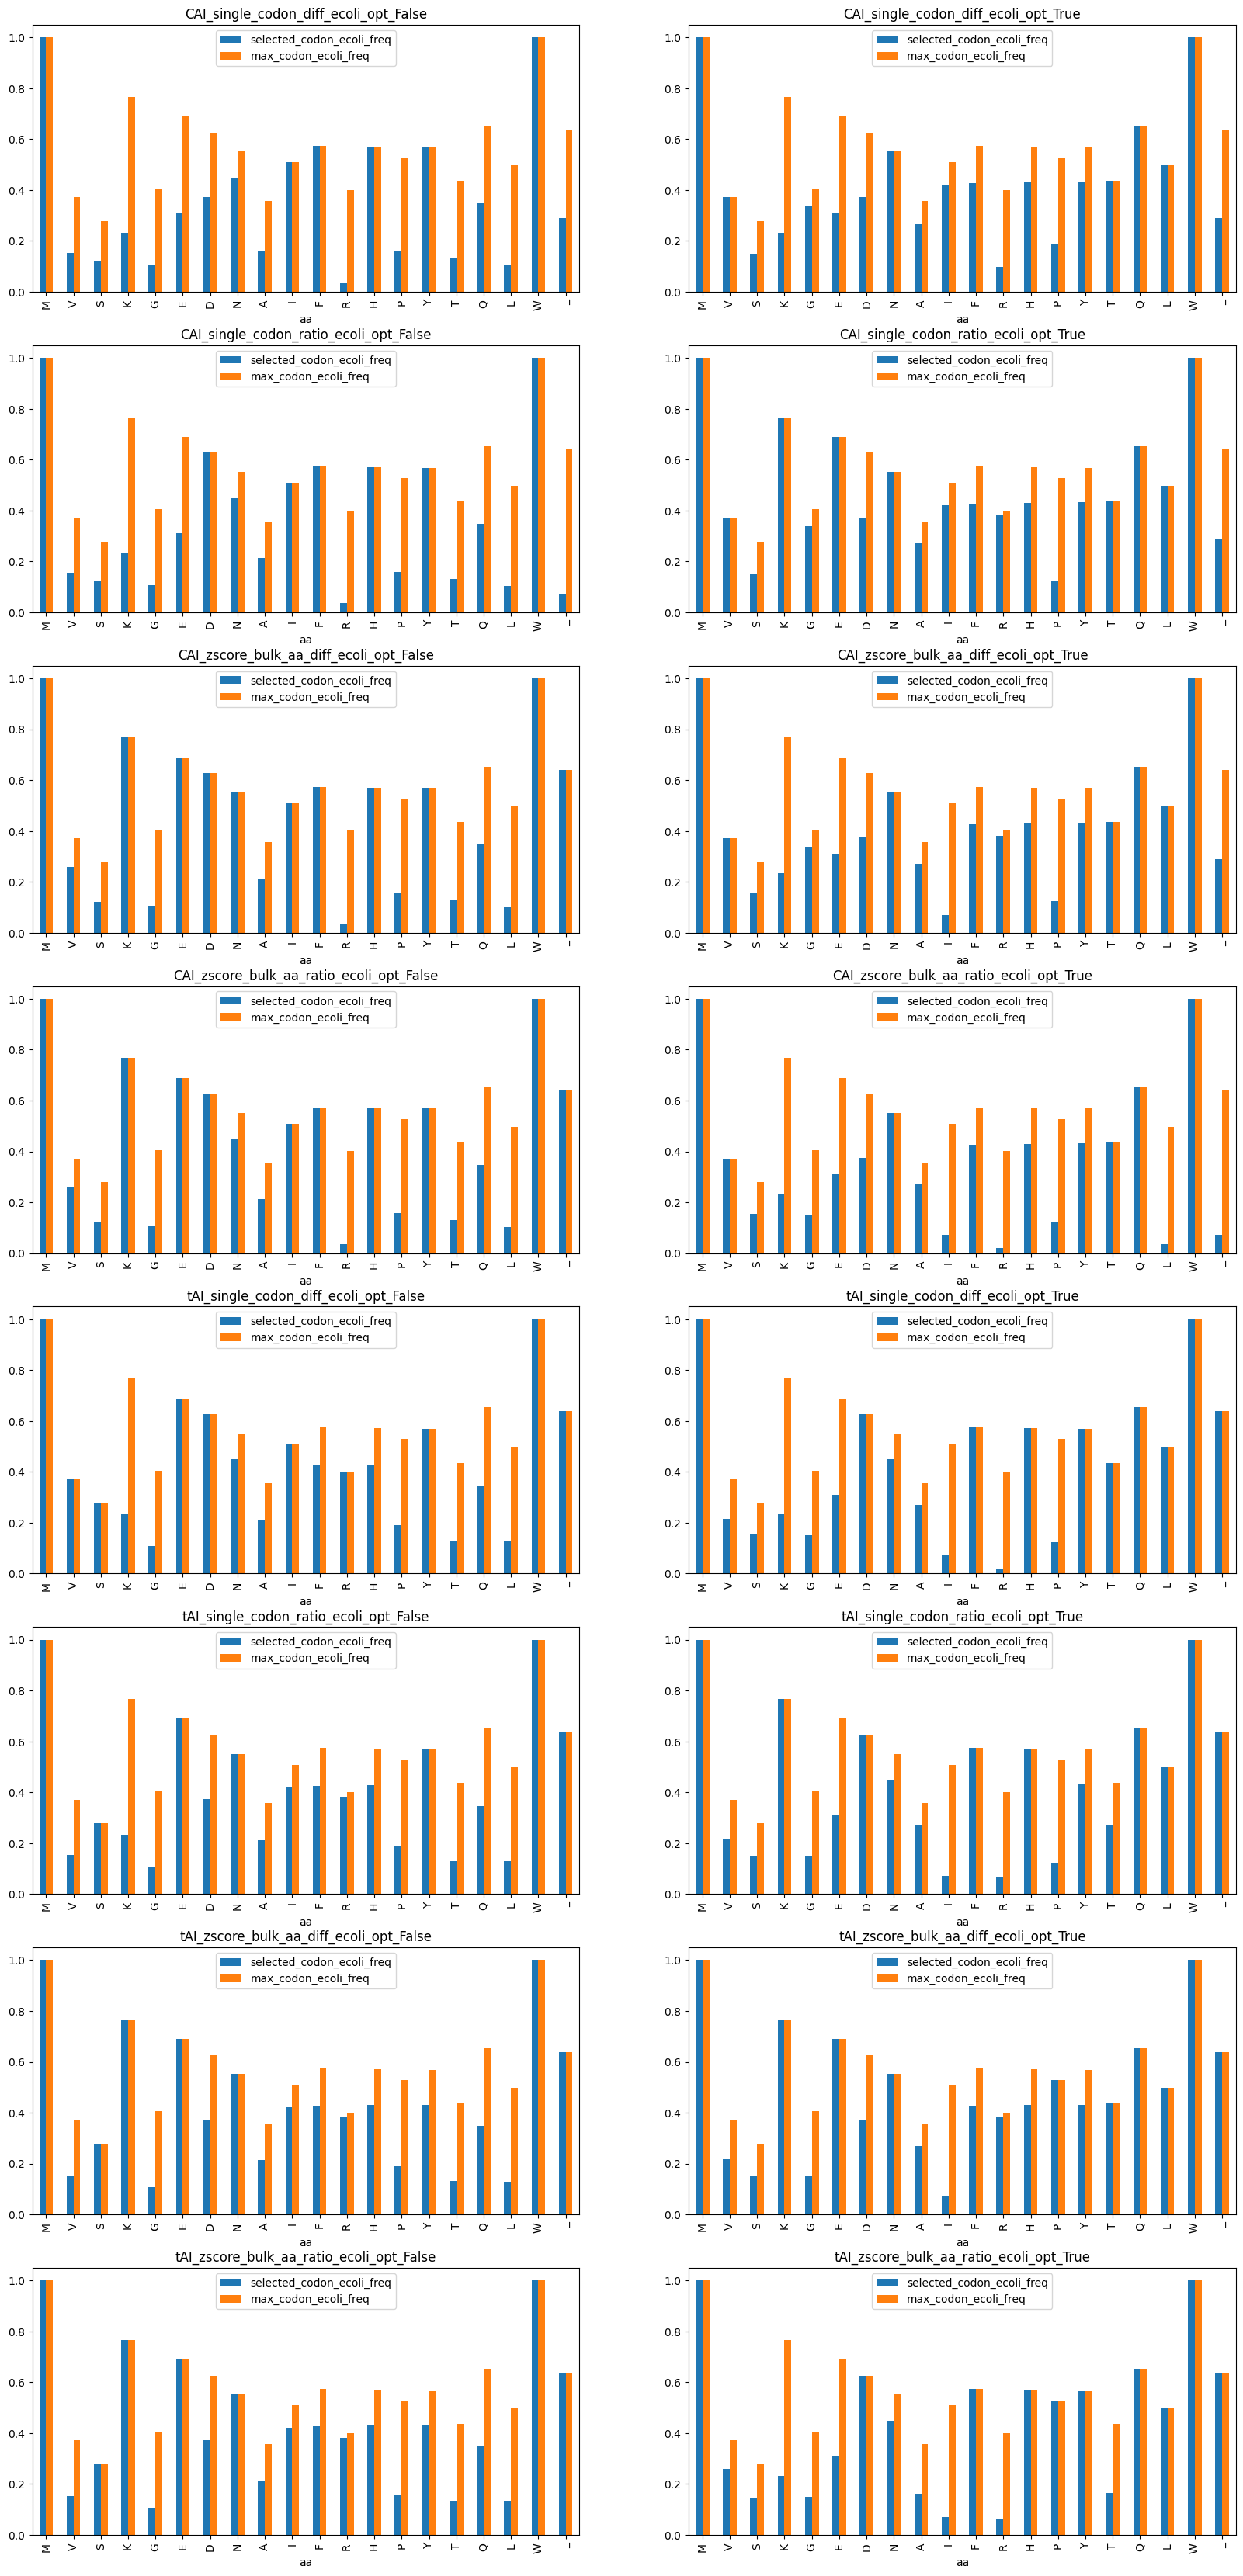

In [58]:
variants_codons_frequencies_df = pd.DataFrame(variants_codons_frequencies)
figure, axis = matplot_plt.subplots(8, 2, figsize=(20,42))
for q in range(variants_codons_frequencies_df.shape[0]):
    x= variants_codons_frequencies_df.iloc[q, :]
    x_df = pd.DataFrame(data={"aa": x.aa, "weight": x.aa_counts, "selected_codon_bacillus_freq": x.bacillus_freq, "selected_codon_ecoli_freq": x.ecoli_freq, "max_codon_bacillus_freq": x.max_bacillus_freq, "max_codon_ecoli_freq": x.max_ecoli_freq})
    x_df.plot.bar(x="aa", y=["selected_codon_ecoli_freq", "max_codon_ecoli_freq"], ax=axis[q//2, q%2],  title=x["variant"])
    # variant_df = pd.DataFrame(data={"aa": x.aa}, "ecoli_freq": x.ecoli_freq)
    # plt = variants_codons_frequencies_df.plot(x="aa", y=["ecoli_freq", "bacillus_freq"], title=x["variant"], ax=axis[q//2, q%2])
    # plt.legend()
x_df